In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python._pywrap_record_io import RecordIterator
from tensorflow.core.util import event_pb2
def summary_iterator(path):
    for r in RecordIterator(path, ""):
        yield event_pb2.Event.FromString(r)

In [3]:
def _read_proto_value(node, path: str):
    for p in path.split('.'):
        node = getattr(node, p, None)
        if node is None:
            return None
    return node

In [4]:
from tensorflow.python.framework.dtypes import DType
def _extract_scalar_from_proto(value, step):
        if value.HasField('simple_value'):  # v1
            simple_value = _read_proto_value(value, 'simple_value')
            #print(simple_value)
            yield step, value.tag, simple_value
        elif value.HasField('metadata'):  # v2 eventfile
            if _read_proto_value(value, 'metadata.plugin_data.plugin_name') == 'scalars':
                t = _read_proto_value(value, 'tensor')
                if t:
                    dtype = DType(t.dtype).as_numpy_dtype
                    simple_value = np.frombuffer(t.tensor_content, dtype=dtype)[0]
                    yield step, value.tag, simple_value

In [5]:
def iter_scalar_summary_from_event_file(event_file):
    for event in summary_iterator(event_file):
        step = int(event.step)
        if not event.HasField('summary'):
            continue
        for value in event.summary.value:
            #print(value)
            yield from _extract_scalar_from_proto(value, step=step)

In [6]:
#event_file = '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:1869_2021-03-13_13-53-295885w68_/events.out.tfevents.1615661625.deeplearn11'
event_file = '/home/timchu/data_backup/m3ac-0225-14,19,02,161098-0/events.out.tfevents.1614280747.deeplearn11.1289369.0'
#event_file = '/home/timchu/ray_mbpo/Walker2d/defaults/seed:1797_2021-03-04_15-14-01dhv3tzbw/events.out.tfevents.1614889285.deeplearn11'

events = summary_iterator(event_file) # return iterator tensorflow.core.util.event_pb2.Event
count = 0
last_step = None
for event in events:
    step = event.step
    #print(event.step)
    if not event.HasField('summary'):
        #print('no summary')
        continue
    else:
        values = event.summary.value  #google.protobuf.pyext._message.RepeatedCompositeContainer
        #print('values:', values)
        for value in values:
            pass
            #print(type(value)) # tensorflow.core.framework.summary_pb2.Value
            #print('value:', value)
            #print(value.tag)
            #print(type(value.simple_value))
            
    if step != 0:
        break

In [7]:
def load_event(event_file):
    from collections import defaultdict
    all_data = defaultdict(dict)  # type: ignore
    for step, tag_name, value in iter_scalar_summary_from_event_file(event_file):
            all_data[step][tag_name] = value
    return all_data
#all_data = load_event('/home/timchu/data_backup/m3ac-0225-14,19,02,161098-0/events.out.tfevents.1614280747.deeplearn11.1289369.0')
#all_data

import matplotlib.pyplot as plt

steps = []
avgs = []
uppers = []
lowers = []
for step in all_data.keys():
    #print(step)
    try:
        avg = all_data[step]['Evaluation/EvalCumDiscountedReward/Average']
        std = all_data[step]['Evaluation/EvalCumDiscountedReward/Std']
    except KeyError:
        continue
    finally:
        steps.append(step)
        avgs.append(avg)
        uppers.append(avg + std)
        lowers.append(avg - std)

#print(len(steps), len(avgs), len(stds))

#plt.style.use('ggplot')
plt.style.use('seaborn')
#plt.style.use('seaborn-darkgrid')

plt.plot(steps, avgs, label='avg', color='r')

#plt.plot(steps, uppers, label='upper')
#plt.plot(steps, lowers, label='lower')
plt.fill_between(steps, uppers, lowers, color='r', alpha=0.5)
plt.legend()
#plt.set_facecolor('gray')


In [8]:
hypo1 = {
    'event_files': [
        '/home/timchu/data_backup/m3ac-0225-14,19,02,161098-0/events.out.tfevents.1614280747.deeplearn11.1289369.0',
        '/home/timchu/data_backup/m3ac-0225-12,05,27,920742-0/events.out.tfevents.1614272731.deeplearn11.1269386.0',
        #'/home/timchu/data_backup/m3ac-0225-01,22,52,806219-0/events.out.tfevents.1614234178.deeplearn11.1164198.0',
        #'/home/timchu/data_backup/m3ac-0224-23,47,11,668769-0/events.out.tfevents.1614228435.deeplearn11.1148402.0',
    ],
    'tag': 'General/CumReward/Average', #'General/CumReward/Average', #tune/evaluation/return-average
    'label': 'hypo1',
    'color': 'r'
}
hypo2 = {
    'event_files': [
        #'/home/timchu/data_backup/m3ac-0225-14,19,02,161098-0/events.out.tfevents.1614280747.deeplearn11.1289369.0',
        #'/home/timchu/data_backup/m3ac-0225-12,05,27,920742-0/events.out.tfevents.1614272731.deeplearn11.1269386.0',
        '/home/timchu/data_backup/m3ac-0225-01,22,52,806219-0/events.out.tfevents.1614234178.deeplearn11.1164198.0',
        '/home/timchu/data_backup/m3ac-0224-23,47,11,668769-0/events.out.tfevents.1614228435.deeplearn11.1148402.0',
    ],
    'tag': 'General/CumReward/Average',
    'label': 'hypo2',
    'color': 'b'
}

exp = {
    'hypos': [hypo1, hypo2],
    'title': 'Evaluation in TruncatedAnt Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}

In [9]:
def load_hypo_events(hypo):
    num_run = len(hypo['event_files'])
    events = {}
    setps_set = set()
    for run in range(num_run):
        events[run] = load_event(hypo['event_files'][run])
        #if run == 0:
        #    setps_set = set(events[run].keys())
        #else:
        #    setps_set.intersection(events[run].keys())
    #steps = sorted(list(setps_set))
    return events
#events = load_hypo_events(hypo2)
#events

In [10]:
def get_events_statistics(hypo, events, smooth=None, x_label=None, y_label=None, title=None):
    num_run = len(events)
    data_stack = []
    valid_steps = []
    setps = sorted(events[0].keys())
    for step in setps:
        entry = np.empty(num_run)
        try:
            for run in range(num_run):
                entry[run] = events[run][step][hypo['tag']]
        except KeyError:
            continue
        else:
            #print('add step:', step)
            data_stack.append(entry)
            valid_steps.append(step)
            #print(step, entry)
    data_stack = np.stack(data_stack) #(step, run)
    if smooth:
        for run in range(num_run):
            data_stack[:,run] = np.convolve(data_stack[:,run], np.ones(smooth)/smooth, 'same')
    
    drop_idx = int(np.ceil(smooth/2))
    valid_steps = valid_steps[:-drop_idx]
    mean = data_stack.mean(axis=1)[:-drop_idx]
    std = data_stack.std(axis=1)[:-drop_idx]
    upper = mean + std
    lower = mean - std
    return valid_steps, mean, upper, lower
#valid_steps, mean, upper, lower = get_events_statistics(hypo1, events)

In [11]:
def draw_exp(exp, smooth=1):
    plt.style.use('seaborn')
    #plt.ticklabel_format(axis='x', style='sci', useMathText=True, scilimits=(0,0))
    #plt.axes().xaxis.set_major_locator(plt.MultipleLocator(1 / 1000))
    for hypo in exp['hypos']:
        events = load_hypo_events(hypo)
        valid_steps, mean, upper, lower = get_events_statistics(hypo, events, smooth=smooth)
        plt.plot(valid_steps, mean, label=hypo['label'], color=hypo['color'])
        plt.fill_between(valid_steps, upper, lower, color=hypo['color'], alpha=0.2)
    plt.legend()
    plt.xlabel(exp['xlabel'])
    plt.ylabel(exp['ylabel'])
    plt.title(exp['title'])
    #plt.ticklabel_format(axis='x', style='sci')
    
#draw_exp(exp)

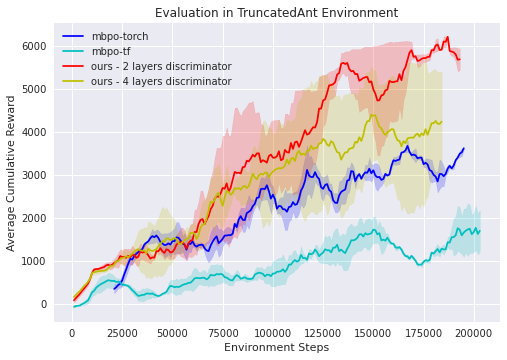

In [12]:
hypo1 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:2353_2021-03-13_13-55-4439sxydu1/events.out.tfevents.1615662417.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:8776_2021-03-13_13-55-55pqnm564f/events.out.tfevents.1615674724.deeplearn11'
    ],
    'tag': 'ray/tune/evaluation/return-average',
    #'tag': 'ray/tune/model/val_loss',
    'label': 'mbpo-torch',
    'color': 'b'
}
hypo2 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:1869_2021-03-13_13-53-295885w68_/events.out.tfevents.1615662306.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:8129_2021-03-13_13-53-32osbqvhjx/events.out.tfevents.1615662331.deeplearn11'
    ],
    'tag': 'ray/tune/evaluation/return-average',
    #'tag': 'ray/tune/model/val_loss',
    'label': 'mbpo-tf',
    'color': 'c'
}
hypo3 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:6629_2021-03-14_14-52-06hxt5ld_8/events.out.tfevents.1615748419.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:5210_2021-03-14_14-52-1314nivg5_/events.out.tfevents.1615748432.deeplearn11'
    ],
    'tag': 'ray/tune/evaluation/return-average',
    #'tag': 'ray/tune/model/val_loss',
    'label': 'ours - 2 layers discriminator',
    'color': 'r'
}
hypo4 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:5677_2021-03-14_16-48-263907kdxv/events.out.tfevents.1615755469.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:5549_2021-03-14_16-48-29a8k8lim2/events.out.tfevents.1615755468.deeplearn11'
    ],
    'tag': 'ray/tune/evaluation/return-average',
    #'tag': 'ray/tune/model/val_loss',
    'label': 'ours - 4 layers discriminator',
    'color': 'y'
}

exp = {
    'hypos': [hypo1, hypo2, hypo3, hypo4],
    'title': 'Evaluation in TruncatedAnt Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}
draw_exp(exp, smooth=15)

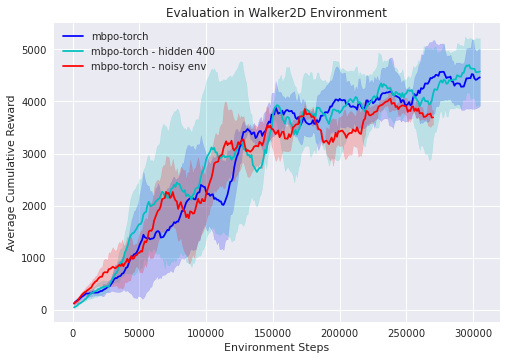

In [13]:
hypo1 = {
    'event_files': [
        '/home/timchu/data/Walker2d/defaults/seed:5578_2021-04-14_14-29-36cnnp6urm/events.out.tfevents.1618425620.deeplearn17',
        '/home/timchu/data/Walker2d/defaults/seed:6728_2021-04-14_14-29-36bl4w065d/events.out.tfevents.1618425630.deeplearn17',
        '/home/timchu/data/Walker2d/defaults/seed:7361_2021-04-14_14-29-35whk8hlcv/events.out.tfevents.1618425626.deeplearn17',
        '/home/timchu/data/Walker2d/defaults/seed:7381_2021-04-14_14-29-37202m2e_n/events.out.tfevents.1618425625.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo-torch',
    'color': 'b'
}
hypo2 = {
    'event_files': [
        '/home/timchu/data/Walker2d/defaults/seed:31_2021-04-14_14-36-55px4afd0y/events.out.tfevents.1618426075.deeplearn17',
        '/home/timchu/data/Walker2d/defaults/seed:3700_2021-04-14_14-36-58ul9f3j3z/events.out.tfevents.1618426093.deeplearn17',
        '/home/timchu/data/Walker2d/defaults/seed:572_2021-04-14_14-36-52xjqn3xwd/events.out.tfevents.1618426084.deeplearn17',
        '/home/timchu/data/Walker2d/defaults/seed:6820_2021-04-14_14-36-54epsiy6m9/events.out.tfevents.1618426080.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo-torch - hidden 400',
    'color': 'c'
}
hypo3 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:4541_2021-04-15_16-14-17dhxgc42v/events.out.tfevents.1618518398.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:6208_2021-04-15_16-14-06nfadnwr3/events.out.tfevents.1618518408.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:6576_2021-04-15_16-14-07x1sxqvm9/events.out.tfevents.1618518404.deeplearn17',
        #'/home/timchu/data/Walker2dNoisyAct/defaults/seed:9161_2021-04-15_16-14-066o4c4r51/events.out.tfevents.1618518404.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo-torch - noisy env',
    'color': 'r'
}
hypo4 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:5677_2021-03-14_16-48-263907kdxv/events.out.tfevents.1615755469.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:5549_2021-03-14_16-48-29a8k8lim2/events.out.tfevents.1615755468.deeplearn11'
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'ours - 4 layers discriminator',
    'color': 'y'
}

exp = {
    'hypos': [hypo1, hypo2, hypo3],
    'title': 'Evaluation in Walker2D Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}
draw_exp(exp, smooth=15)

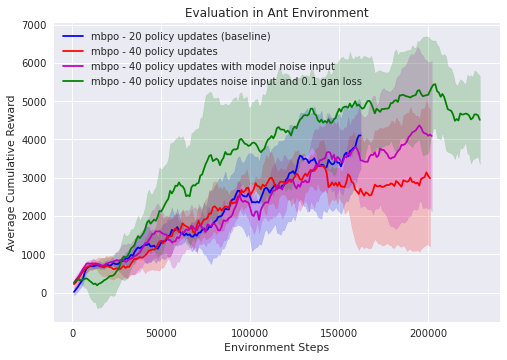

In [14]:
hypo1 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:1758_2021-03-23_01-25-45bwe3xdnz/events.out.tfevents.1616477551.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:3908_2021-03-23_01-25-49iwylpcsz/events.out.tfevents.1616477554.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:6529_2021-03-23_01-25-39q1mw8knw/events.out.tfevents.1616477548.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:6663_2021-03-23_01-25-57ot44sqng/events.out.tfevents.1616477569.deeplearn11',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 20 policy updates (baseline)',
    'color': 'b'
}
hypo2 = {
    'event_files': [
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:1032_2021-04-23_13-42-582eu1v076/events.out.tfevents.1619200590.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:1462_2021-04-23_13-42-57oiqgji1i/events.out.tfevents.1619200574.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:2939_2021-04-23_13-42-5695d396eg/events.out.tfevents.1619200579.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:8605_2021-04-23_13-42-56lpqvqpgk/events.out.tfevents.1619200577.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 40 policy updates noise input and 0.1 gan loss',
    'color': 'g'
}
hypo3 = {
    'event_files': [
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:2571_2021-04-27_16-46-13btlbdii1/events.out.tfevents.1619557130.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:2599_2021-04-27_16-46-11dbxv0d6y/events.out.tfevents.1619557133.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:2774_2021-04-27_16-46-14i7y0dyvk/events.out.tfevents.1619557128.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:9976_2021-04-27_16-46-15aj2ge4f2/events.out.tfevents.1619557112.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 40 policy updates',
    'color': 'r'
}
hypo4 = {
    'event_files': [
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:1740_2021-04-27_16-55-43z4ckch0e/events.out.tfevents.1619557676.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:4343_2021-04-27_16-55-386roz1yjd/events.out.tfevents.1619557670.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:5220_2021-04-27_16-55-29dq500qzk/events.out.tfevents.1619557659.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:6687_2021-04-27_16-55-34szdkz6zy/events.out.tfevents.1619557660.deeplearn17',

    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 40 policy updates with model noise input',
    'color': 'm'
}
hypo5 = {
    'event_files': [
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:2447_2021-04-20_22-14-14kn5q9kbv/events.out.tfevents.1618971720.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:8599_2021-04-20_22-14-13n5omcmia/events.out.tfevents.1618971711.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:8682_2021-04-20_22-14-16obti6qt_/events.out.tfevents.1618971719.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:9081_2021-04-20_22-14-18277819vf/events.out.tfevents.1618971721.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo-torch - 0.3 env noise',
    'color': 'y'
}
hypo6 = {
    'event_files': [
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:6434_2021-04-20_23-17-29cqngvexf/events.out.tfevents.1618975622.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:8554_2021-04-20_23-17-31y_9gdebh/events.out.tfevents.1618975626.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:8554_2021-04-20_23-17-36bfe8skvh/events.out.tfevents.1618975633.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:8981_2021-04-20_23-17-33amf2nl6_/events.out.tfevents.1618975629.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo-torch - 0.3 env noise with 0.1 gan loss',
    'color': 'c'
}


exp = {
    'hypos': [hypo1, hypo3, hypo4, hypo2],
    'title': 'Evaluation in Ant Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}
draw_exp(exp, smooth=11)

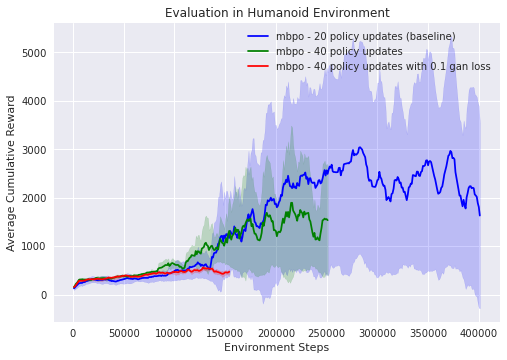

In [15]:
hypo1 = {
    'event_files': [
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:1169_2021-04-30_16-55-298ni6lz4l/events.out.tfevents.1619816611.deeplearn17',
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:8435_2021-04-30_16-55-259fekd6s3/events.out.tfevents.1619816598.deeplearn17',
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:9529_2021-04-30_16-55-20awenlkdx/events.out.tfevents.1619816594.deeplearn17',
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:9699_2021-04-30_16-55-32se7v3njq/events.out.tfevents.1619816617.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 20 policy updates (baseline)',
    'color': 'b'
}
hypo2 = {
    'event_files': [
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:2189_2021-04-30_16-56-53fb3mrbs0/events.out.tfevents.1619817113.deeplearn17',
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:2235_2021-04-30_16-56-50ifhzdivf/events.out.tfevents.1619817097.deeplearn17',
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:5247_2021-04-30_16-56-470n00ax09/events.out.tfevents.1619817057.deeplearn17',
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:7727_2021-04-30_16-56-54en_oulxx/events.out.tfevents.1619817100.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 40 policy updates',
    'color': 'g'
}
hypo3 = {
    'event_files': [
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:2542_2021-05-01_02-27-23qx3liizu/events.out.tfevents.1619851410.deeplearn17',
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:483_2021-05-01_02-27-31qes3jjb6/events.out.tfevents.1619851396.deeplearn17',
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:7790_2021-05-01_02-27-26zz7g2wt4/events.out.tfevents.1619851383.deeplearn17',
        '/home/timchu/data/HumanoidTruncatedObs/defaults/seed:9384_2021-05-01_02-27-27kiuv7zg_/events.out.tfevents.1619918975.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 40 policy updates with 0.1 gan loss',
    'color': 'r'
}
hypo4 = {
    'event_files': [
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:1740_2021-04-27_16-55-43z4ckch0e/events.out.tfevents.1619557676.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:4343_2021-04-27_16-55-386roz1yjd/events.out.tfevents.1619557670.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:5220_2021-04-27_16-55-29dq500qzk/events.out.tfevents.1619557659.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:6687_2021-04-27_16-55-34szdkz6zy/events.out.tfevents.1619557660.deeplearn17',

    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 40 policy updates with model noise input',
    'color': 'm'
}
hypo5 = {
    'event_files': [
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:2447_2021-04-20_22-14-14kn5q9kbv/events.out.tfevents.1618971720.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:8599_2021-04-20_22-14-13n5omcmia/events.out.tfevents.1618971711.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:8682_2021-04-20_22-14-16obti6qt_/events.out.tfevents.1618971719.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:9081_2021-04-20_22-14-18277819vf/events.out.tfevents.1618971721.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo-torch - 0.3 env noise',
    'color': 'y'
}
hypo6 = {
    'event_files': [
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:6434_2021-04-20_23-17-29cqngvexf/events.out.tfevents.1618975622.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:8554_2021-04-20_23-17-31y_9gdebh/events.out.tfevents.1618975626.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:8554_2021-04-20_23-17-36bfe8skvh/events.out.tfevents.1618975633.deeplearn17',
        '/home/timchu/data/AntTruncatedObsNoisyAct/defaults/seed:8981_2021-04-20_23-17-33amf2nl6_/events.out.tfevents.1618975629.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo-torch - 0.3 env noise with 0.1 gan loss',
    'color': 'c'
}


exp = {
    'hypos': [hypo1, hypo2, hypo3],
    'title': 'Evaluation in Humanoid Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}
draw_exp(exp, smooth=11)

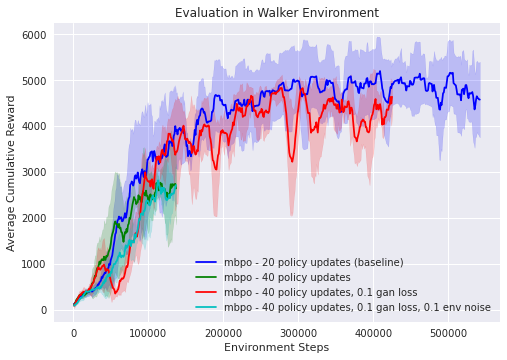

In [16]:
hypo1 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:1211_2021-05-03_16-07-563_vks0wj/events.out.tfevents.1620072886.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:1686_2021-05-03_16-07-55rtddp1j_/events.out.tfevents.1620072885.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:7349_2021-05-03_16-07-53s914iag3/events.out.tfevents.1620072897.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:7979_2021-05-03_16-07-50km4_4rzu/events.out.tfevents.1620072895.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 20 policy updates (baseline)',
    'color': 'b'
}
hypo2 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:3991_2021-05-03_16-09-468_0v7uf_/events.out.tfevents.1620073469.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:4008_2021-05-03_16-09-4438ubnfj8/events.out.tfevents.1620073465.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:4198_2021-05-03_16-09-50f3dbxhsl/events.out.tfevents.1620073502.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:7692_2021-05-03_16-09-484630ri8q/events.out.tfevents.1620073508.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 40 policy updates',
    'color': 'g'
}
hypo3 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:1775_2021-05-03_16-15-49gc60of1o/events.out.tfevents.1620074019.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:3435_2021-05-03_16-15-46qi_l5l61/events.out.tfevents.1620074036.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:4088_2021-05-03_16-15-530jtyuxwq/events.out.tfevents.1620074037.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:8238_2021-05-03_16-15-51ltp_7_0x/events.out.tfevents.1620074006.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 40 policy updates, 0.1 gan loss',
    'color': 'r'
}
hypo4 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:2318_2021-05-03_16-17-39gbephdwb/events.out.tfevents.1620074147.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:698_2021-05-03_16-17-362h9n6xl4/events.out.tfevents.1620074160.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:9204_2021-05-03_16-17-33ll1zpli1/events.out.tfevents.1620074160.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:9340_2021-05-03_16-17-31_mel67ln/events.out.tfevents.1620074153.deeplearn17',

    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 40 policy updates, 0.1 gan loss, 0.1 env noise',
    'color': 'c'
}

exp = {
    'hypos': [hypo1, hypo2, hypo3, hypo4],
    'title': 'Evaluation in Walker Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}
draw_exp(exp, smooth=11)

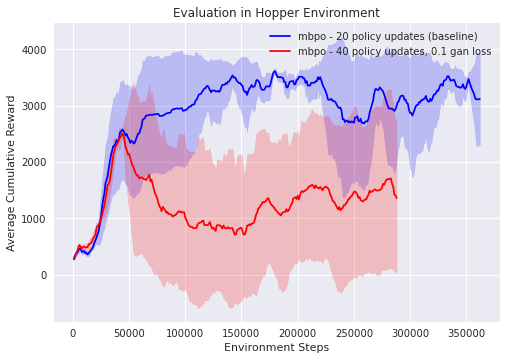

In [17]:
hypo1 = {
    'event_files': [
        '/home/timchu/data/Hopper/defaults/seed:3624_2021-05-05_14-45-297ccq7cri/events.out.tfevents.1620240917.deeplearn17',
        '/home/timchu/data/Hopper/defaults/seed:4537_2021-05-05_14-45-35znohyyxk/events.out.tfevents.1620240984.deeplearn17',
        '/home/timchu/data/Hopper/defaults/seed:7081_2021-05-05_14-45-246za4n0fb/events.out.tfevents.1620240916.deeplearn17',
        '/home/timchu/data/Hopper/defaults/seed:9986_2021-05-05_14-45-31l3fc1e58/events.out.tfevents.1620240949.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 20 policy updates (baseline)',
    'color': 'b'
}
hypo2 = {
    'event_files': [
        '/home/timchu/data/Hopper/defaults/seed:1898_2021-05-05_14-48-46q20q83r4/events.out.tfevents.1620241592.deeplearn17',
        '/home/timchu/data/Hopper/defaults/seed:2033_2021-05-05_14-48-38_nz8l_na/events.out.tfevents.1620241605.deeplearn17',
        '/home/timchu/data/Hopper/defaults/seed:61_2021-05-05_14-48-428u1mfuix/events.out.tfevents.1620241556.deeplearn17',
        '/home/timchu/data/Hopper/defaults/seed:814_2021-05-05_14-48-40g5m4p542/events.out.tfevents.1620241581.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 40 policy updates, 0.1 gan loss',
    'color': 'r'
}


exp = {
    'hypos': [hypo1, hypo2],
    'title': 'Evaluation in Hopper Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}
draw_exp(exp, smooth=11)

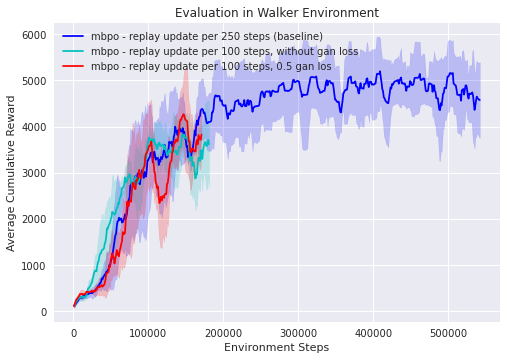

In [28]:
hypo1 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:1211_2021-05-03_16-07-563_vks0wj/events.out.tfevents.1620072886.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:1686_2021-05-03_16-07-55rtddp1j_/events.out.tfevents.1620072885.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:7349_2021-05-03_16-07-53s914iag3/events.out.tfevents.1620072897.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:7979_2021-05-03_16-07-50km4_4rzu/events.out.tfevents.1620072895.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - replay update per 250 steps (baseline)',
    'color': 'b'
}

hypo2 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:1380_2021-05-12_00-16-11dr1n1vmn/events.out.tfevents.1620794049.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:274_2021-05-12_00-16-09t5b5fy1q/events.out.tfevents.1620794056.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:488_2021-05-12_00-16-05y4l3f5ds/events.out.tfevents.1620794069.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:9256_2021-05-12_00-16-02zor9x825/events.out.tfevents.1620794044.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - replay update per 100 steps, without gan loss',
    'color': 'c'
}
hypo3 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:251_2021-05-12_00-13-51jm3obze1/events.out.tfevents.1620793924.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:5099_2021-05-12_00-13-566u0egpd5/events.out.tfevents.1620793914.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:8733_2021-05-12_00-13-59dyu76puy/events.out.tfevents.1620793878.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:2755_2021-05-12_00-14-02vc0imipi/events.out.tfevents.1620793899.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - replay update per 100 steps, 0.5 gan los',
    'color': 'r'
}
hypo4 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:6594_2021-05-19_14-56-32t1s172zd/events.out.tfevents.1621451291.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 40 policy updates, 0.5 gan los',
    'color': 'c'
}


exp = {
    'hypos': [hypo1, hypo2, hypo3],
    'title': 'Evaluation in Walker Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}
draw_exp(exp, smooth=11)

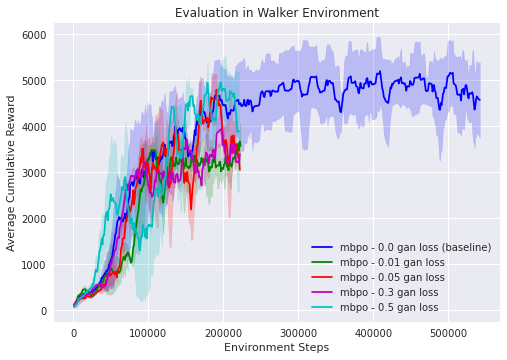

In [30]:
hypo1 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:1211_2021-05-03_16-07-563_vks0wj/events.out.tfevents.1620072886.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:1686_2021-05-03_16-07-55rtddp1j_/events.out.tfevents.1620072885.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:7349_2021-05-03_16-07-53s914iag3/events.out.tfevents.1620072897.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:7979_2021-05-03_16-07-50km4_4rzu/events.out.tfevents.1620072895.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 0.0 gan loss (baseline)',
    'color': 'b'
}

hypo2 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:6188_2021-05-11_01-33-36m065oiqm/events.out.tfevents.1620711958.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:9203_2021-05-11_01-33-33a90hkak8/events.out.tfevents.1620711937.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 0.01 gan loss',
    'color': 'g'
}
hypo3 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:1207_2021-05-11_01-34-13yab9d99n/events.out.tfevents.1620712009.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:9142_2021-05-11_01-34-12c4ren0tv/events.out.tfevents.1620711981.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 0.05 gan loss',
    'color': 'r'
}
hypo4 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:2606_2021-05-11_01-35-0367s_4d6u/events.out.tfevents.1620712052.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:7385_2021-05-11_01-35-00saafsv_e/events.out.tfevents.1620712027.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 0.3 gan loss',
    'color': 'm'
}
hypo5 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:2875_2021-05-11_01-35-50t4ghs6ik/events.out.tfevents.1620712084.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:7648_2021-05-11_01-35-48n_gwwtvr/events.out.tfevents.1620712083.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 0.5 gan loss',
    'color': 'c'
}


exp = {
    'hypos': [hypo1, hypo2, hypo3, hypo4, hypo5],
    'title': 'Evaluation in Walker Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}
draw_exp(exp, smooth=11)

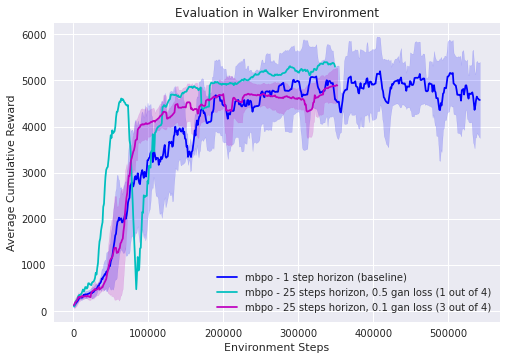

In [55]:
hypo1 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:1211_2021-05-03_16-07-563_vks0wj/events.out.tfevents.1620072886.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:1686_2021-05-03_16-07-55rtddp1j_/events.out.tfevents.1620072885.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:7349_2021-05-03_16-07-53s914iag3/events.out.tfevents.1620072897.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:7979_2021-05-03_16-07-50km4_4rzu/events.out.tfevents.1620072895.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 1 step horizon (baseline)',
    'color': 'b'
}

hypo2 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:6594_2021-05-19_14-56-32t1s172zd/events.out.tfevents.1621451291.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 25 steps horizon, 0.5 gan loss (1 out of 4)',
    'color': 'c'
}
hypo3 = {
    'event_files': [
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:2134_2021-05-19_15-18-03my4xmjgm/events.out.tfevents.1621452568.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:4075_2021-05-19_15-18-029206kr1f/events.out.tfevents.1621452559.deeplearn17',
        '/home/timchu/data/Walker2dNoisyAct/defaults/seed:8338_2021-05-19_15-18-04okq5a_9y/events.out.tfevents.1621452585.deeplearn17',
    ],
    'tag': 'ray/tune/evaluation/return-average',
    'label': 'mbpo - 25 steps horizon, 0.1 gan loss (3 out of 4)',
    'color': 'm'
}

exp = {
    'hypos': [hypo1, hypo2, hypo3],
    'title': 'Evaluation in Walker Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}
draw_exp(exp, smooth=11)